# ***Team Modelling***

In [31]:
# Import modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, matthews_corrcoef, f1_score, classification_report, fbeta_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Error_analysis import calculate_cost

RSEED= 42

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# Import Dataset

df= pd.read_csv('data/training_preprocessed.csv')

In [3]:
y= df.FraudResult
df.drop("FraudResult", axis=1, inplace=True)
X= df
X.drop(["TransactionId"], axis=1, inplace=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)
X_test_unscaled = X_test.copy()

In [5]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [6]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier()>

In [7]:
y_pred = rf.predict(X_test)

In [8]:
confusion_matrix(y_test, y_pred)

array([[23860,     8],
       [   18,    30]])

In [9]:
print(recall_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.625
0.8123324115971176


In [10]:
minmax = MinMaxScaler()
stdsc = StandardScaler()

In [11]:
X_train['ModAmount'] = stdsc.fit_transform(pd.DataFrame(X_train['ModAmount']))
X_test['ModAmount'] = stdsc.transform(pd.DataFrame(X_test['ModAmount']));

In [ ]:
X_test_unscaled

In [13]:
""" rand_param_grid = {'n_estimators': np.linspace(10, 100).astype(int),
                    'max_depth': [None] + list(np.linspace(3, 100).astype(int)),
                    'max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
                    'max_leaf_nodes': [None] + list(np.linspace(10, 50).astype(int)),
                    'min_samples_split': [2, 5, 10, 50]
                    }

scorer = make_scorer(matthews_corrcoef)

rand_grid = RandomizedSearchCV(rf, param_distributions=rand_param_grid, n_jobs=-1, scoring=scorer, n_iter=100, verbose=0, random_state=RSEED) """;

In [14]:
# param grid is small because we narrow down using optimal parameters from long grid search

param_grid = {'n_estimators': [125],#np.linspace(100, 200, 5).astype(int),
                    #'max_depth': [None] + list(np.linspace(3, 100, 10).astype(int)),
                    'max_features': [0.75], #['sqrt']+ list(np.arange(0.5, 1, 0.25)),
                    'max_leaf_nodes': list(np.linspace(80, 200, 5).astype(int)),# + [None],
                    'min_samples_split':[5]# [2, 5, 10, 50]
                    }

scorer = make_scorer(matthews_corrcoef)

rand_grid = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, scoring=scorer, verbose=5)

In [15]:
rand_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 4/5] END max_features=0.75, max_leaf_nodes=80, min_samples_split=5, n_estimators=125;, score=0.852 total time=  10.7s
[CV 1/5] END max_features=0.75, max_leaf_nodes=80, min_samples_split=5, n_estimators=125;, score=0.965 total time=  11.8s
[CV 1/5] END max_features=0.75, max_leaf_nodes=110, min_samples_split=5, n_estimators=125;, score=0.965 total time=  11.8s
[CV 2/5] END max_features=0.75, max_leaf_nodes=110, min_samples_split=5, n_estimators=125;, score=0.912 total time=  11.8s
[CV 3/5] END max_features=0.75, max_leaf_nodes=80, min_samples_split=5, n_estimators=125;, score=0.967 total time=  11.9s
[CV 5/5] END max_features=0.75, max_leaf_nodes=80, min_samples_split=5, n_estimators=125;, score=0.947 total time=  12.0s
[CV 3/5] END max_features=0.75, max_leaf_nodes=110, min_samples_split=5, n_estimators=125;, score=0.949 total time=  12.4s
[CV 2/5] END max_features=0.75, max_leaf_nodes=80, min_samples_split=5, n_estimator

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.75],
                         'max_leaf_nodes': [80, 110, 140, 170, 200],
                         'min_samples_split': [5], 'n_estimators': [125]},
             scoring=make_scorer(matthews_corrcoef), verbose=5)

In [16]:
rand_grid.best_params_

{'max_features': 0.75,
 'max_leaf_nodes': 80,
 'min_samples_split': 5,
 'n_estimators': 125}

In [17]:
y_pred_grid = rand_grid.best_estimator_.predict(X_test)

In [73]:
print(f"Recall is:{round(recall_score(y_test, y_pred_grid),3)}")
print(f"MCC is:{round(matthews_corrcoef(y_test, y_pred_grid),3)}")
print(f"F1 is:{round(f1_score(y_test, y_pred_grid),3)}")

Recall is:0.792
MCC is:0.878
F1 is:0.874


<AxesSubplot:>

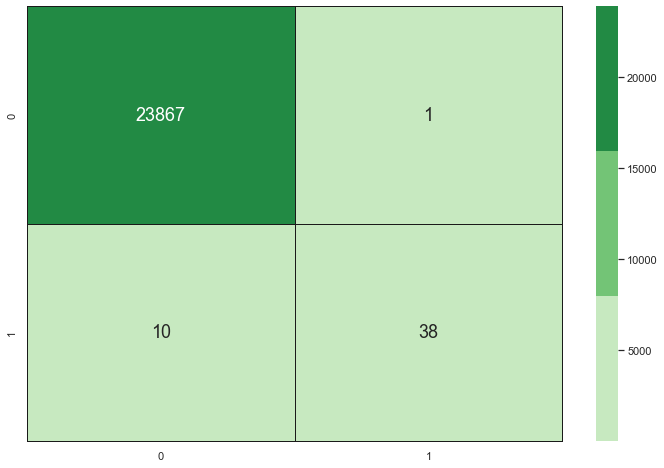

In [46]:
matrix = confusion_matrix(y_test, y_pred_grid)
colormap = sns.color_palette("Greens", 3)
sns.heatmap(data=matrix, annot=True, fmt='.0f', annot_kws={"fontsize":18}, linewidths=1, linecolor='k', cmap=colormap, clip_on=False)

In [20]:
calculate_cost(X_test_unscaled, y_test, y_pred_grid)

You saved the company 86.02 Million UGX
The company still has to reimburse frauds with a total of 11.8 Million UGX
Total money saved is 74.22 Million UGX


In [21]:
"""{'max_features': 0.75,
 'max_leaf_nodes': 80,
 'min_samples_split': 5,
 'n_estimators': 125}

 Recall is:0.792
MCC is:0.878

You saved the company 86.02 Million UGX
The company still has to reimburse frauds with a total of 11.8 Million UGX
Total money saved is 74.22 Million UGX""";

In [22]:
"""param_grid = {'n_estimators': #np.linspace(100, 200, 5).astype(int),
                    'max_depth': [None] + list(np.linspace(3, 100, 10).astype(int)),
                    'max_features': [0.75], ['sqrt']+ list(np.arange(0.5, 1, 0.25)),
                    'max_leaf_nodes': list(np.linspace(80, 100, 5).astype(int)) + [None],
                    'min_samples_split':[2, 5, 10, 50]
                    }

scorer = make_scorer(matthews_corrcoef)

rand_grid = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, scoring=scorer, verbose=5)

Recall is:0.7916666666666666
ROC-AUC is:0.895812384782973
F1 is:0.8735632183908045
F-beta is:0.9313725490196079
MCC is:0.8780632982539146

{'max_features': 0.75,
 'max_leaf_nodes': 100,
 'min_samples_split': 5,
 'n_estimators': 125}""";

## ***Feature importance calculations and plotting***

In [70]:
Names = list(df.columns.values)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=Names).sort_values(ascending=False)

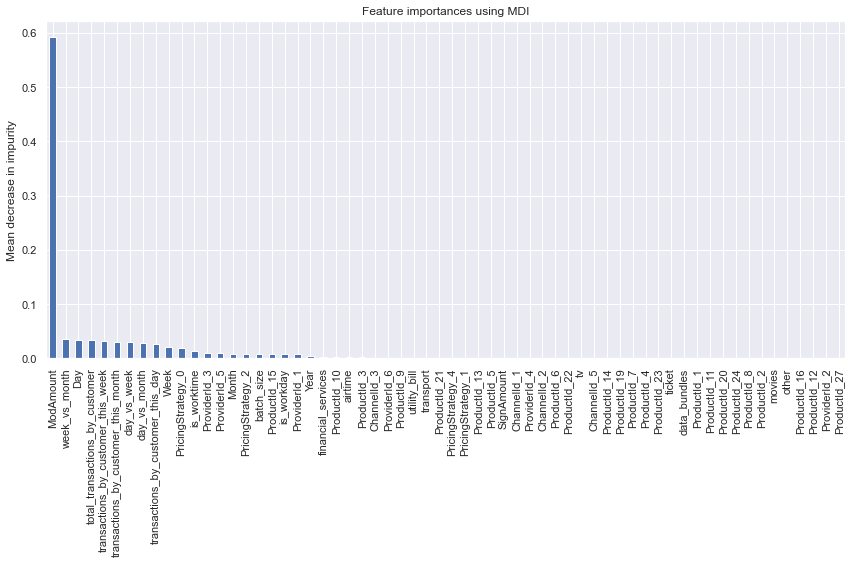

In [72]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation = 90)
fig.tight_layout()

In [77]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.4f' % (i,v))

Feature: 0, Score: 0.0046
Feature: 1, Score: 0.0090
Feature: 2, Score: 0.0212
Feature: 3, Score: 0.0345
Feature: 4, Score: 0.0075
Feature: 5, Score: 0.0137
Feature: 6, Score: 0.0007
Feature: 7, Score: 0.5929
Feature: 8, Score: 0.0073
Feature: 9, Score: 0.0000
Feature: 10, Score: 0.0106
Feature: 11, Score: 0.0007
Feature: 12, Score: 0.0093
Feature: 13, Score: 0.0015
Feature: 14, Score: 0.0000
Feature: 15, Score: 0.0025
Feature: 16, Score: 0.0000
Feature: 17, Score: 0.0000
Feature: 18, Score: 0.0009
Feature: 19, Score: 0.0001
Feature: 20, Score: 0.0076
Feature: 21, Score: 0.0000
Feature: 22, Score: 0.0001
Feature: 23, Score: 0.0000
Feature: 24, Score: 0.0000
Feature: 25, Score: 0.0011
Feature: 26, Score: 0.0004
Feature: 27, Score: 0.0000
Feature: 28, Score: 0.0000
Feature: 29, Score: 0.0000
Feature: 30, Score: 0.0021
Feature: 31, Score: 0.0000
Feature: 32, Score: 0.0008
Feature: 33, Score: 0.0006
Feature: 34, Score: 0.0000
Feature: 35, Score: 0.0000
Feature: 36, Score: 0.0014
Feature: 37